In [1]:
#load and vis a few seqmented images in the images_CNN folder
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import Image, ImageSequence
img_list = glob.glob('images_CNN/F?_im.TIF')+glob.glob('images_CNN/F??_im.TIF')
img_list = sorted(img_list)
mask_list = glob.glob('images_CNN/*mask.h5')
mask_list = sorted(mask_list)
fluo_gfp = glob.glob('images_CNN/*GFP_im.TIF')
fluo_gfp = sorted(fluo_gfp)
fluo_rfp = glob.glob('images_CNN/*RFP_im.TIF')
fluo_rfp = sorted(fluo_rfp)
print( len(img_list), len(mask_list) , len(fluo_gfp), len(fluo_rfp  )   )
dataset = {}
for i in range(len(img_list)):
    dataset[i] = { 'img': img_list[i], 'mask': mask_list[i], 'gfp': fluo_gfp[i], 'rfp': fluo_rfp[i]  }
print(dataset)



11 11 11 11
{0: {'img': 'images_CNN/F10_im.TIF', 'mask': 'images_CNN/F10_mask.h5', 'gfp': 'images_CNN/F10_GFP_im.TIF', 'rfp': 'images_CNN/F10_RFP_im.TIF'}, 1: {'img': 'images_CNN/F11_im.TIF', 'mask': 'images_CNN/F11_mask.h5', 'gfp': 'images_CNN/F11_GFP_im.TIF', 'rfp': 'images_CNN/F11_RFP_im.TIF'}, 2: {'img': 'images_CNN/F1_im.TIF', 'mask': 'images_CNN/F1_mask.h5', 'gfp': 'images_CNN/F1_GFP_im.TIF', 'rfp': 'images_CNN/F1_RFP_im.TIF'}, 3: {'img': 'images_CNN/F2_im.TIF', 'mask': 'images_CNN/F2_mask.h5', 'gfp': 'images_CNN/F2_GFP_im.TIF', 'rfp': 'images_CNN/F2_RFP_im.TIF'}, 4: {'img': 'images_CNN/F3_im.TIF', 'mask': 'images_CNN/F3_mask.h5', 'gfp': 'images_CNN/F3_GFP_im.TIF', 'rfp': 'images_CNN/F3_RFP_im.TIF'}, 5: {'img': 'images_CNN/F4_im.TIF', 'mask': 'images_CNN/F4_mask.h5', 'gfp': 'images_CNN/F4_GFP_im.TIF', 'rfp': 'images_CNN/F4_RFP_im.TIF'}, 6: {'img': 'images_CNN/F5_im.TIF', 'mask': 'images_CNN/F5_mask.h5', 'gfp': 'images_CNN/F5_GFP_im.TIF', 'rfp': 'images_CNN/F5_RFP_im.TIF'}, 7: {'i

In [2]:
from PIL import Image, ImageEnhance

def adjust_brightness_contrast(input_image_path, output_image_path, brightness=3, contrast=3):
    # Open the image
    image = Image.open(input_image_path)
    
    # Adjust brightness
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(brightness)
    
    # Adjust contrast
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(contrast)
    
    # Save the modified image
    image.save(output_image_path)

In [3]:

import skimage.measure as measure
import copy

def output_contours( m , cl , verbose = False):
    contours = measure.find_contours(m, .9)
    if verbose:
        plt.imshow(m)
        for n, contour in enumerate(contours):
            plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
        plt.show()

    #output contours of each mask to file
    #divide x and y coordinates by total image size
    #to get values between 0 and 1  
    #<class-index> <x1> <y1> <x2> <y2> ... <xn> <yn>
    lines = []
    for c in contours:
        coords = []
        for i in range(0,c.shape[0]):
            coords.append( (float(c[i][1]) / m.shape[0]) )
            coords.append( (float(c[i][0]) / m.shape[1]) )
        line = str(cl) + ' ' + ' '.join([str(c) for c in coords]) + '\n'
        lines.append(line)
    return lines

def split_mask(mask, crop = 1024):
    #custom encoding with 3 classes
    mask = mask[0:crop, 0:crop]
    mask1 = copy.deepcopy(mask)
    mask1[ (mask1 > 0) & (mask1 < 1000)] =  1
    mask1[mask1 > 1] = 0 

    mask2 = copy.deepcopy(mask)
    mask2[mask2 == 1] = 0
    mask2[ (mask2 > 1000) & (mask2 < 2000)] =  1
    mask2[mask2 > 1] = 0

    mask3 = copy.deepcopy(mask)
    mask3[mask3 == 1] = 0
    mask3[ (mask3 >= 2000) ] =  1
    mask3[mask3 > 1] = 0
    return mask1, mask2, mask3

def mask2contourfile( mask , outputfile , verbose = False):
    if type(mask) == list:
        m1,m2,m3 = mask
    else:
        m1, m2, m3 = split_mask(mask)
    lines = output_contours(m1, 0 , verbose = verbose)
    lines += output_contours(m2, 1, verbose = verbose)
    lines += output_contours(m3, 2, verbose = verbose)
    
    with open(outputfile, 'w') as f:
        for l in lines:
            f.write(l)
    return  outputfile


In [4]:
#clean finaldataset folder
import shutil
overwite = True
if overwite:
    try:
        shutil.rmtree('./datasets/')
    except:
        pass
    os.mkdir('./datasets/')
    os.mkdir('./datasets/train')
    os.mkdir('./datasets/train/images/')
    os.mkdir('./datasets/train/labels/')
    
    os.mkdir('./datasets/test')
    os.mkdir('./datasets/test/images/')
    os.mkdir('./datasets/test/labels/')
    
    os.mkdir('./datasets/val/')
    os.mkdir('./datasets/val/images')
    os.mkdir('./datasets/val/labels')


In [5]:
#stack equivalent frames together from img, gfp and rfp and transform them to a jpg image
import cv2
import numpy as np
import os
import tqdm

verbose = False
crop = 1024

import pickle
with open('scalers.pkl' , 'rb') as scalerdump:
    scalers = pickle.loads( scalerdump.read())
print(scalers)


def yield_frames(img,crop=1024 , verbose = False ,scaler = True):
    for i, page in enumerate(ImageSequence.Iterator(img)):
        if verbose == True:
            plt.imshow(np.array(page))
            plt.show()
        if crop is not None:
            page = np.array(page)[0:crop, 0:crop]
        if scaler==True:
            page = (page - page.min()) / (page.max() - page.min()) * 255
        yield page

count = 0

for sample in dataset:
    maskfile = dataset[sample]['mask']
    maskh5 = h5py.File(maskfile, 'r')
    for group in maskh5.keys():
        for frame in maskh5[group]:
            mask = np.array( maskh5[group][frame] ,  dtype = np.uint16 )
            
            if np.sum(mask) > 0 :
                mask =  mask[0:crop, 0:crop]
                dataset[sample]['maskmatrix'] = mask
                print( group, frame)
                print(np.unique(mask) )
                if verbose == True:
                    plt.imshow(mask)
                    plt.show()
                converted = mask2contourfile(mask, maskfile +'converted.txt' , verbose = verbose)
                dataset[sample]['mask_poly'] = converted
                break

    print('loading img')
    img = Image.open(dataset[sample]['img'])
    img = [frame for frame in yield_frames(img,scaler = True , verbose=verbose)]
    print('loading gfp')
    
    gfp = Image.open(dataset[sample]['gfp'])
    gfp = [frame for frame in yield_frames(gfp,scaler = True,verbose=verbose)]
    
    print('loading rfp')
    rfp = Image.open(dataset[sample]['rfp'])
    rfp = [frame for frame in yield_frames(rfp,scaler = True,verbose=verbose)]
    dataset[sample]['stack']= []
    dataset[sample]['stack_mat'] ={}
    #stack the frames together
    for i in tqdm.tqdm(range(len(img))):
        im = np.stack([img[i], gfp[i], rfp[i]], axis=-1)
        dataset[sample]['stack_mat'][i] = im

        #im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        
        cv2.imwrite('./datasets/train/images/img_'+str(count)+'.png', im )
        adjust_brightness_contrast('./datasets/train/images/img_'+str(count)+'.png','./datasets/train/images/img_'+str(count)+'.png')

        dataset[sample]['stack'].append('./datasets/train/images/img_'+str(count)+'.png')
        
        #save the correct mask file
        shutil.copyfile(dataset[sample]['mask_poly'], './datasets/train/labels/img_'+str(count)+'.txt' )
        count += 1

[RobustScaler()]
FOV0 T5
[   0    1    2    4 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011
 1012 1013 1014 1015 1016 1017 1018 1020 1021 2001 2002 2003]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


FOV0 T5
[   0 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013
 1014 1015 1016 1017 1020 1021 1022 1023 2001 2002]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7    8   10   11 1001 1002 1003
 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017
 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1031 1032
 1033 1034 1035 1037 1038 1039 1042 1043 1044 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2011]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7    8    9   10   13 1001 1002
 1003 1004 1007 1008 1009 1010 1013 1014 1015 1016 1017 1018 1020 1021
 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035
 1036 1037 1038 1039 1040 1041 1042 1043 1044 1046 1047 1048 1049 1050
 1051 1052 1053 1054 1055 1056 1059 1060 1061 1062 1063 1064 1065 1066
 1075 1076 1077 1078 2001 2002 2003 2006]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7 1001 1002 1003 1004 1005 1006
 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020
 1021 1022 1023 1024 1025 1026 1028 1032 1033 1039 1040 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2014]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   21 1001 1003 1004 1005 1006 1007 1009 1010 1011
 1012 1013 1014 1015 1017 1018 1019 1020 1021 1022 1023 1026 1027 1028
 1029 1030 1031 1032 1033 1034 1036 1037 1038 1039 1051 2001 2002 2003
 2004 2005 2011 2012]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


FOV0 T5
[   0    1    2    3    6    7 1001 1002 1003 1004 1005 1006 1007 1008
 1012 1013 1015 1016 1017 1019 1020 1021 1022 1024 2001 2002 2003 2004
 2006]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


FOV0 T5
[   0    1    2 1001 1002 1003 1004 1005 1007]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


FOV0 T5
[   0 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


FOV0 T5
[   0    1    2    4 1001 1003 1004 1005 1006 1007 1008 1009 1010 1011
 1012 1013 1014 1015 1016 1018 1019 1020 1021 1022 1023 1025 1029 1035
 2001 2002]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


FOV0 T5
[   0    1    2    3    4 1001 1002 1003 1004 1005 1006 1007 1008 1009
 1011 1012 1013 1014 1015 1016 1023 2002 2003]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


loading img
loading gfp
loading rfp


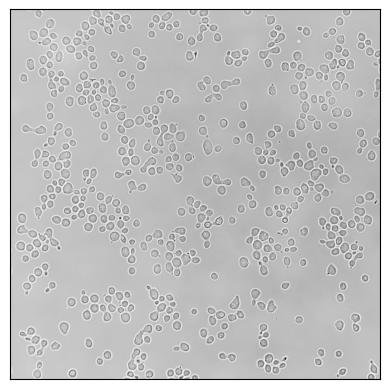

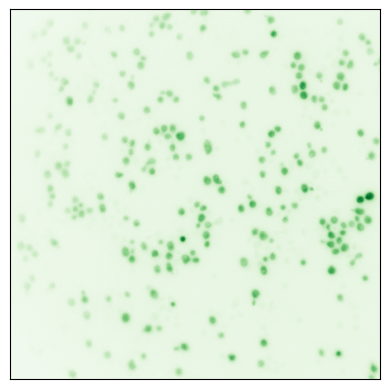

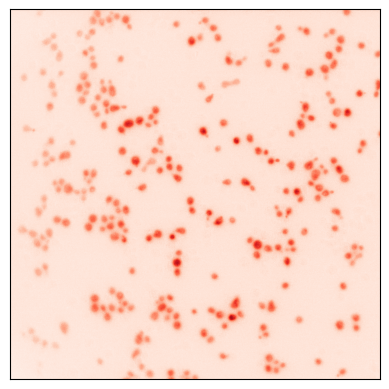

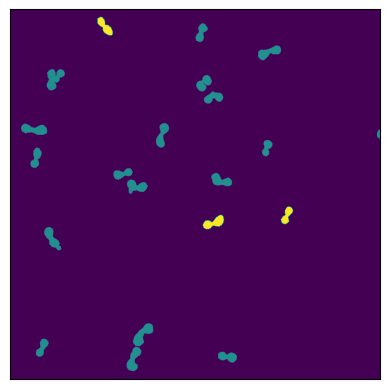

In [6]:
check_example = True
import matplotlib.pyplot as plt
%matplotlib inline

if check_example == True:
    print('loading img' )
    img = Image.open(dataset[0]['img'])
    img = [frame for frame in yield_frames(img,verbose=False)]
    print('loading gfp')

    gfp = Image.open(dataset[0]['gfp'])
    gfp = [frame for frame in yield_frames(gfp,verbose=False)]
    
    print('loading rfp')
    rfp = Image.open(dataset[0]['rfp'])
    rfp = [frame for frame in yield_frames(rfp,verbose=False)]

    ax = plt.imshow( img[0] , cmap = 'Greys')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    
    ax = plt.imshow( gfp[0] , cmap = 'Greens')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    
    ax = plt.imshow( rfp[0] , cmap = 'Reds')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    
    
    ax = plt.imshow( dataset[0]['maskmatrix'] )
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    
    


In [7]:
from sklearn.preprocessing import RobustScaler
import numpy as np
import pickle



# Initialize the RobustScaler
scaler_bf = RobustScaler()

images_bf = np.stack([ dataset[sample]['stack_mat'][frame] for sample in dataset for frame in dataset[sample]['stack_mat'] ])
print('stacks' , images_bf.shape)

image_stack_bf = images_bf.reshape(-1, images_bf.shape[0])

print( 'fitting scalers ' ) 
scaler_bf.fit(image_stack_bf)

scalers = [scaler_bf]
print('scalers', scalers)
with open('scalers.pkl' , 'wb') as scalerdump:
    scalerdump.write(pickle.dumps(scalers))

stacks (77, 1024, 1024, 3)
fitting scalers 
scalers [RobustScaler()]


In [8]:
#apply data augmentation
#image augmentation for training

import cv2
import random
import numpy as np

def random_rotation(image, masks, angle_range):
    angle = random.uniform(-angle_range, angle_range)
    image =  Image.fromarray(  np.array( np.ones(image.shape)*256 - Image.fromarray(image)).astype(np.uint8) )
    image = image.rotate(angle)
    masks = [ Image.fromarray(m) for m in masks ]
    masks = [ m.rotate(angle) for m in masks ]
    return np.array(image), masks

def random_flip(image, masks):
    if random.random() > 0.5:
        image = cv2.flip(image, 1)
        masks = [ cv2.flip(np.array(m), 1) for m in masks]
    return image, masks

def random_augmentation(image, masks, angle_range, crop_size):
    
    image, masks = random_rotation(image, masks, angle_range)
    
    image, masks = random_flip(image, masks)
   
    
    #image, mask = random_crop(image, mask, crop_size)
    return image, masks

#resize to original size
def resize(image, mask, size):
    image = cv2.resize(image, size)
    mask = cv2.resize(mask, size)
    return image, mask

#apply augmentation and then resize to original size
def augment_and_resize(image, masks, angle_range=180, crop_size=900, size=[1024,1024]):
    image = image.astype(np.uint8)
    image, masks = random_augmentation(image, masks, angle_range, crop_size)
    masks = [np.array(m) for m in masks ]
    #image, masks = resize(image, masks, size)
    return image, masks

In [9]:

augmented_folder = 'augmented/'

In [10]:
import shutil
overwite = True
if overwite:
    try:
        shutil.rmtree(augmented_folder)
    except:
        pass
    os.mkdir(augmented_folder)
    os.mkdir(augmented_folder+'train')
    os.mkdir(augmented_folder+'train/images/')
    os.mkdir(augmented_folder+'train/labels/')
    os.mkdir(augmented_folder +'test')
    os.mkdir(augmented_folder+'test/images/')
    os.mkdir(augmented_folder + 'test/labels/')
    os.mkdir(augmented_folder +'val/')
    os.mkdir(augmented_folder +'val/images')
    os.mkdir(augmented_folder + 'val/labels')


In [46]:
verbose = False
import tqdm 
x_augment = 10
augmented = {}

count = 0
for sample in tqdm.tqdm(dataset):
    augmented[sample] ={}
    for frame in dataset[sample]['stack_mat']:
        image = dataset[sample]['stack_mat'][frame]
        mask = dataset[sample]['maskmatrix']
        masks = split_mask(mask)
        for i in range(x_augment):
            img , masks = augment_and_resize(image,masks)
            
            for m in masks:
                m[m>0] = 1
                
            if count < 10 and verbose == True:
                plt.imshow( img[:,:,0] , cmap = 'Greys')
                plt.colorbar( location = 'left')
                plt.show()
            augmented[sample]['mask'] = mask
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(augmented_folder+'train/images/img_'+str(count)+'.png', im )
            augmented[sample]['img'] = augmented_folder+'train/images/img_'+str(count)+'.png'
            m1,m2,m3 = masks
            lines = output_contours(m1, 0 , verbose = verbose)
            lines += output_contours(m2, 1, verbose = verbose)
            lines += output_contours(m3, 2, verbose = verbose)
            with open(augmented_folder + 'train/labels/img_'+ str(count)+ '.txt', 'w') as f:
                for l in lines:
                    f.write(l)
            augmented[sample]['mask_poly'] = augmented_folder  +'train/labels/img_'+ str(count)+ '.txt'
            #add polygons
            count+=1
            

100%|██████████| 11/11 [02:40<00:00, 14.55s/it]


In [11]:
#move a fraction of the training data and corresponding labels to val
import random
import shutil
import os

datasetdir = 'datasets/'#augmented_folder

files = os.listdir(datasetdir +'train/images/')
print(files[0:100], '...')
random.shuffle(files)
val_files = files[:int(len(files)*.1)]
for f in val_files:
    shutil.move(datasetdir + 'train/images/'+f, datasetdir+'val/images/'+f)
    shutil.move(datasetdir +'train/labels/'+f.replace('.png', '.txt'), datasetdir + 'val/labels/'+f.replace('.png', '.txt'))

    
files = os.listdir(datasetdir+'train/images/')
random.shuffle(files)

test_files = files[:int(len(files)*.1)]
for f in test_files:
    shutil.move(datasetdir + 'train/images/'+f, datasetdir + 'test/images/'+f)
    shutil.move(datasetdir + 'train/labels/'+f.replace('.png', '.txt'), datasetdir + 'test/labels/'+f.replace('.png', '.txt'))



['img_21.png', 'img_55.png', 'img_43.png', 'img_59.png', 'img_60.png', 'img_65.png', 'img_17.png', 'img_28.png', 'img_52.png', 'img_22.png', 'img_76.png', 'img_37.png', 'img_69.png', 'img_47.png', 'img_33.png', 'img_48.png', 'img_54.png', 'img_50.png', 'img_40.png', 'img_73.png', 'img_26.png', 'img_11.png', 'img_39.png', 'img_18.png', 'img_61.png', 'img_38.png', 'img_19.png', 'img_45.png', 'img_7.png', 'img_75.png', 'img_67.png', 'img_12.png', 'img_36.png', 'img_8.png', 'img_13.png', 'img_62.png', 'img_5.png', 'img_63.png', 'img_31.png', 'img_6.png', 'img_46.png', 'img_58.png', 'img_25.png', 'img_51.png', 'img_30.png', 'img_68.png', 'img_2.png', 'img_44.png', 'img_70.png', 'img_66.png', 'img_1.png', 'img_42.png', 'img_29.png', 'img_74.png', 'img_3.png', 'img_0.png', 'img_24.png', 'img_20.png', 'img_23.png', 'img_41.png', 'img_16.png', 'img_9.png', 'img_57.png', 'img_34.png', 'img_32.png', 'img_15.png', 'img_4.png', 'img_10.png', 'img_53.png', 'img_71.png', 'img_14.png', 'img_72.png', '

In [12]:
#create traininging yaml file for the dataset

outyaml = """
train: train
val: val
test: test

names: 
    0: f
    1: h
    2: l
"""

with open('./dataset.yaml', 'w') as f:
    f.write(outyaml)


In [13]:
from ultralytics import YOLO
modelpath = 'yolov8n-seg_yfusion.pt'
import os


overwrite = False
if os.path.exists(modelpath) and overwrite == False:
    model = YOLO(modelpath)
else:
    #train the model
    model = YOLO("yolov8n-seg.pt")

In [130]:
train = True
if train == True:
    results = model.train(
            batch=5,
            device=0,
            data='./dataset.yaml',
            epochs=5000,
            imgsz=1024,
            box=0.1,
            scale=1,
            lr0=0.005
        
        )

Ultralytics YOLOv8.1.10 🚀 Python-3.12.1 torch-2.2.0 CUDA:0 (NVIDIA A100-PCIE-40GB, 40339MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg_yfusion.pt, data=./dataset.yaml, epochs=5000, time=None, patience=50, batch=5, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train3666, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

train: Scanning /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/datasets/train/labels.cache... 63 images, 0 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<?, ?it/s]
/work/FAC/FBM/DBC/cdessim2/default/dmoi/miniconda3/envs/torch/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/datasets/val/labels.cache... 7 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7/7 [00:00<?, ?it/s]
/work/FAC/FBM/DBC/cdessim2/default/dmoi/miniconda3/envs/torch/lib/python3.12/site-packages/torch/ut

Plotting labels to runs/segment/train3666/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005078125), 76 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs/segment/train3666
Starting training for 5000 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     1/5000      21.9G    0.01791    0.03311      1.061      1.025        248       1024: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all          7        231      0.957      0.861      0.915      0.722      0.956      0.859       0.91       0.56



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     2/5000      21.4G     0.0142    0.02815     0.8702     0.9559        206       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all          7        231      0.932      0.904      0.919      0.751      0.932      0.904      0.916      0.632



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     3/5000      19.8G    0.01455    0.02678     0.8339     0.9452        225       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all          7        231       0.92      0.901      0.908      0.729      0.925        0.9      0.904      0.628



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     4/5000        19G    0.01954    0.03242      1.027     0.9535        377       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all          7        231      0.905      0.901      0.913      0.744      0.905      0.903      0.913      0.624



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     5/5000      22.5G     0.0146    0.02609     0.8282     0.9421        154       1024: 100%|██████████| 13/13 [00:04<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all          7        231      0.913      0.883      0.921      0.757      0.911      0.881       0.92      0.621



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     6/5000      23.6G    0.01417    0.02607     0.7985     0.9203         93       1024: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all          7        231      0.905      0.908       0.92      0.743      0.905      0.908       0.92      0.627



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     7/5000      22.5G    0.01428     0.0263     0.7615     0.9221        149       1024: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all          7        231      0.896      0.911      0.917      0.747      0.896      0.911      0.918      0.626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     8/5000      24.3G    0.01539    0.02673     0.8553     0.9227        149       1024: 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all          7        231      0.915        0.9       0.91      0.751      0.915        0.9       0.91      0.623



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     9/5000      18.8G    0.01513    0.02729     0.9002     0.9454        130       1024: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all          7        231      0.907      0.814      0.894      0.725      0.907      0.814      0.894      0.603



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    10/5000      18.6G    0.01688    0.03026     0.9652       0.95         38       1024: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all          7        231      0.938      0.821      0.904      0.739      0.939      0.823      0.904      0.573



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    11/5000      19.6G    0.01598     0.0297     0.9297     0.9516        159       1024: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all          7        231      0.929      0.873      0.912      0.748      0.931      0.875      0.897       0.57



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    12/5000      21.8G    0.01699    0.03036     0.9762     0.9646        167       1024: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all          7        231      0.894       0.91      0.917       0.76      0.867      0.885      0.891        0.6



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    13/5000        17G    0.01452    0.02621     0.8435     0.9278         46       1024: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all          7        231      0.877      0.908      0.919      0.757      0.875      0.906      0.918      0.641



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    14/5000      18.4G    0.01542    0.02846     0.8848      0.939        199       1024: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all          7        231      0.944       0.89      0.918      0.763      0.944       0.89      0.917      0.655



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    15/5000      21.5G    0.01562    0.02849     0.8614     0.9382        335       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all          7        231      0.968      0.896      0.919      0.747      0.968      0.896      0.919      0.662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    16/5000      21.2G    0.01453    0.02734     0.8385     0.9517         56       1024: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all          7        231      0.967      0.907      0.921      0.755      0.967      0.907      0.921      0.652



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    17/5000      20.2G    0.01355    0.02532      0.764     0.9129         67       1024: 100%|██████████| 13/13 [00:04<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all          7        231      0.947      0.907      0.921      0.758      0.947      0.907      0.921      0.621



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    18/5000      19.4G     0.0151    0.02759     0.8381     0.9207        168       1024: 100%|██████████| 13/13 [00:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all          7        231      0.955      0.895      0.924      0.748      0.955      0.895      0.924      0.569



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    19/5000      19.8G    0.01295    0.02495     0.7713     0.9206        107       1024: 100%|██████████| 13/13 [00:04<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all          7        231      0.963      0.896      0.923      0.718      0.961      0.894      0.923      0.522



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    20/5000      19.9G    0.01447    0.02677      0.839     0.9335         68       1024: 100%|██████████| 13/13 [00:04<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all          7        231      0.926        0.9      0.924      0.715      0.925      0.898      0.924      0.517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    21/5000      18.7G    0.01332    0.02518     0.7618     0.9165         78       1024: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all          7        231      0.947      0.907      0.924       0.73      0.947      0.907      0.924      0.561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    22/5000      17.9G    0.01667    0.02981     0.8947      0.931        235       1024: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all          7        231      0.941      0.919      0.922      0.759      0.941      0.919      0.924      0.596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    23/5000      21.4G     0.0152    0.02778     0.8408     0.9363        117       1024: 100%|██████████| 13/13 [00:04<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all          7        231      0.982      0.897      0.924      0.772      0.982      0.897      0.925      0.606



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    24/5000        21G    0.01303    0.02409     0.7364     0.9172         51       1024: 100%|██████████| 13/13 [00:04<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all          7        231      0.984      0.896      0.927      0.796      0.984      0.896      0.927      0.634



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    25/5000      16.5G    0.01394    0.02547     0.7512     0.9046        185       1024: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all          7        231      0.981      0.899      0.929      0.804      0.981      0.899      0.929      0.645



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    26/5000      18.7G    0.01454     0.0268     0.8366      0.926        163       1024: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all          7        231      0.979      0.899      0.931      0.799      0.973      0.901      0.931      0.641



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    27/5000      25.9G    0.01373    0.02498     0.7863     0.9123         79       1024: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all          7        231      0.981      0.887      0.931      0.783      0.981      0.887       0.93       0.63



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    28/5000      21.3G    0.01366    0.02525     0.7455     0.9095        108       1024: 100%|██████████| 13/13 [00:04<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all          7        231      0.981      0.913      0.929      0.762      0.981      0.913      0.929      0.622



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    29/5000      19.5G    0.01396    0.02609     0.7652     0.9324        240       1024: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all          7        231       0.98      0.915      0.927      0.771       0.98      0.915      0.927      0.618



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    30/5000      20.9G    0.01463     0.0274     0.9163     0.9457         54       1024: 100%|██████████| 13/13 [00:04<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all          7        231      0.981      0.907      0.927      0.766      0.981      0.907      0.927      0.616



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    31/5000      17.7G    0.01342    0.02435     0.7693     0.9128        128       1024: 100%|██████████| 13/13 [00:04<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all          7        231      0.961       0.89      0.927      0.775      0.959      0.889      0.927      0.612



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    32/5000      19.5G    0.01583    0.02883     0.8831     0.9296         82       1024: 100%|██████████| 13/13 [00:04<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all          7        231      0.936      0.859      0.929       0.78      0.939      0.854      0.927      0.631



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    33/5000      19.4G    0.01463    0.02769     0.8405     0.9188         67       1024: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all          7        231      0.942      0.864       0.93      0.782       0.94      0.862      0.929       0.64



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    34/5000      17.2G    0.01562    0.02941     0.8735     0.9332        163       1024: 100%|██████████| 13/13 [00:04<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all          7        231       0.96      0.919      0.929      0.794       0.96      0.919      0.929      0.642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    35/5000      17.5G    0.01322    0.02328     0.7147     0.9057        105       1024: 100%|██████████| 13/13 [00:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all          7        231       0.97      0.921      0.928      0.801       0.97      0.921      0.928      0.646



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    36/5000      19.3G    0.01339    0.02517     0.7463     0.9094         96       1024: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all          7        231      0.984      0.921      0.927      0.794      0.984      0.921      0.927      0.639



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    37/5000      22.7G     0.0136    0.02481     0.7642     0.9009        225       1024: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all          7        231      0.982      0.924      0.927      0.796      0.982      0.924      0.927       0.64



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    38/5000        22G    0.01396     0.0248     0.7635      0.902        137       1024: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all          7        231       0.98      0.923      0.927      0.796       0.98      0.923      0.927      0.643



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    39/5000      18.4G    0.01439    0.02699     0.7533     0.9035        204       1024: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all          7        231      0.973       0.91      0.926      0.791      0.973       0.91      0.926      0.664



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    40/5000      18.1G    0.01412    0.02686     0.7767     0.9111        159       1024: 100%|██████████| 13/13 [00:04<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all          7        231      0.955      0.915      0.928      0.798      0.955      0.915      0.928       0.67



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    41/5000      20.9G    0.01495    0.02657     0.8007     0.9023        228       1024: 100%|██████████| 13/13 [00:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all          7        231      0.965      0.918      0.926      0.788      0.965      0.918      0.926      0.658



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    42/5000      22.4G    0.01352    0.02521     0.7601     0.9139         66       1024: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all          7        231       0.97      0.908      0.926      0.795       0.97      0.908      0.926      0.655



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    43/5000      24.2G    0.01618    0.02937     0.8842     0.9219        146       1024: 100%|██████████| 13/13 [00:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all          7        231      0.979      0.879      0.925      0.788      0.979      0.879      0.925       0.66



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    44/5000      19.1G    0.01242    0.02217     0.6603     0.8937        266       1024: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all          7        231      0.962      0.919      0.927      0.787      0.962      0.919      0.927      0.648



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    45/5000      17.6G    0.01375    0.02553     0.7529     0.9083         52       1024: 100%|██████████| 13/13 [00:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all          7        231      0.949       0.92      0.927      0.787      0.949       0.92      0.927      0.635



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    46/5000      19.2G    0.01308    0.02386      0.718     0.9056        100       1024: 100%|██████████| 13/13 [00:04<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all          7        231      0.979      0.901      0.927       0.77      0.979      0.901      0.927      0.638



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    47/5000      21.6G    0.01381    0.02462     0.7538     0.9104         60       1024: 100%|██████████| 13/13 [00:04<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all          7        231      0.956      0.916      0.926      0.763      0.956      0.916      0.926       0.63



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    48/5000      18.5G    0.01337    0.02443     0.7126      0.905        159       1024: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all          7        231      0.975      0.898      0.925      0.772      0.975      0.898      0.925      0.626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    49/5000      21.3G    0.01224    0.02171     0.6716     0.9025        107       1024: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all          7        231      0.948      0.874      0.922      0.762      0.948      0.874      0.922      0.613



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    50/5000      21.5G    0.01621      0.029     0.8465     0.9237        324       1024: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all          7        231      0.854      0.922      0.913      0.751      0.902      0.878      0.913      0.609



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    51/5000      23.5G    0.01324    0.02382     0.7484     0.9106         55       1024: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all          7        231      0.872      0.913      0.903       0.73      0.874      0.915      0.903      0.597



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    52/5000        23G    0.01396    0.02513     0.7536     0.9045        229       1024: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all          7        231      0.875      0.915      0.909      0.745      0.875      0.915      0.909      0.599



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    53/5000      18.8G    0.01398    0.02604     0.7702     0.9107         60       1024: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all          7        231      0.915      0.905      0.917      0.773      0.929      0.878      0.915      0.632



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    54/5000      16.4G     0.0137    0.02509     0.7388     0.9032         73       1024: 100%|██████████| 13/13 [00:04<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all          7        231      0.977      0.885      0.922      0.791      0.977      0.885      0.921      0.662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    55/5000        24G    0.01408    0.02557      0.753     0.9058        101       1024: 100%|██████████| 13/13 [00:04<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all          7        231       0.98      0.904      0.925      0.788       0.98      0.904      0.923      0.647



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    56/5000      18.9G    0.01235    0.02245      0.646     0.8917         88       1024: 100%|██████████| 13/13 [00:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all          7        231      0.979      0.906      0.926      0.794      0.979      0.906      0.926      0.639



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    57/5000      18.3G    0.01367    0.02578     0.7351     0.9058        114       1024: 100%|██████████| 13/13 [00:04<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all          7        231       0.98      0.904      0.927      0.797       0.98      0.904      0.927      0.643



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    58/5000      18.3G     0.0142      0.026     0.7657     0.9014         92       1024: 100%|██████████| 13/13 [00:04<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all          7        231      0.969      0.919      0.926      0.792      0.969      0.919      0.926      0.638



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    59/5000      19.7G    0.01399    0.02417     0.7316     0.9204         64       1024: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all          7        231      0.978      0.914      0.926      0.794      0.978      0.914      0.926      0.639



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    60/5000      21.2G    0.01473    0.02551     0.7734     0.9089        212       1024: 100%|██████████| 13/13 [00:04<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all          7        231      0.988      0.913      0.927      0.791      0.988      0.913      0.927      0.654



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    61/5000      18.3G    0.01591    0.02821     0.8322     0.9102        157       1024: 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all          7        231      0.991      0.905      0.927      0.771      0.991      0.905      0.927       0.66



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    62/5000      18.8G    0.01399    0.02558     0.7476     0.9007        195       1024: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all          7        231      0.991      0.907      0.928      0.758      0.991      0.907      0.928      0.626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    63/5000      20.3G     0.0141    0.02459     0.7213     0.8937        172       1024: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all          7        231      0.988      0.911      0.928      0.758      0.988      0.911      0.928       0.61



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    64/5000      19.5G    0.01398    0.02509     0.7568     0.9012        153       1024: 100%|██████████| 13/13 [00:04<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all          7        231      0.992      0.902      0.927      0.747      0.992      0.902      0.927      0.603



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    65/5000      20.4G    0.01406    0.02485     0.7537     0.8964        247       1024: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all          7        231      0.992      0.904      0.927       0.76      0.992      0.904      0.927      0.616



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    66/5000      18.7G    0.01542    0.02701     0.8261     0.9283        211       1024: 100%|██████████| 13/13 [00:04<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all          7        231      0.992      0.906      0.927      0.767      0.992      0.906      0.927      0.643



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    67/5000      20.3G    0.01398    0.02565     0.7423     0.8948        224       1024: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all          7        231       0.99      0.905      0.929      0.781       0.99      0.905      0.929      0.664



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    68/5000      23.2G    0.01449    0.02614     0.7418      0.892        173       1024: 100%|██████████| 13/13 [00:04<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all          7        231      0.987      0.909       0.93      0.798      0.987      0.909       0.93      0.674



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    69/5000      20.7G    0.01586    0.02892     0.8253     0.9118        144       1024: 100%|██████████| 13/13 [00:04<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all          7        231       0.99      0.907      0.929      0.801       0.99      0.907      0.929      0.669



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    70/5000      22.9G    0.01384    0.02587      0.749     0.9007         57       1024: 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all          7        231      0.983      0.902      0.927      0.777      0.983      0.902      0.927      0.649



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    71/5000      20.6G    0.01325    0.02386     0.6917      0.896        260       1024: 100%|██████████| 13/13 [00:04<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all          7        231      0.973      0.905      0.926      0.772      0.973      0.905      0.926      0.641



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    72/5000      18.4G     0.0127    0.02305     0.6675     0.9012        173       1024: 100%|██████████| 13/13 [00:04<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all          7        231      0.985      0.897      0.926      0.764      0.985      0.897      0.926      0.642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    73/5000      18.7G    0.01477    0.02644     0.7752      0.914        245       1024: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all          7        231      0.983      0.905      0.927      0.773      0.983      0.905      0.927      0.662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    74/5000      18.1G    0.01332    0.02466     0.7079     0.9112        214       1024: 100%|██████████| 13/13 [00:04<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all          7        231      0.984      0.905      0.929      0.792      0.984      0.905      0.929      0.677



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    75/5000      20.5G    0.01378    0.02416      0.743     0.9084        147       1024: 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all          7        231      0.992      0.899      0.931      0.796      0.992      0.899      0.931      0.681



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    76/5000      19.4G    0.01322     0.0233     0.6988     0.8994        123       1024: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all          7        231      0.978      0.922      0.933      0.804      0.976       0.92      0.933      0.681



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    77/5000        21G    0.01348     0.0245     0.7061     0.8993         83       1024: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all          7        231      0.979      0.922      0.931      0.783      0.976       0.92      0.931      0.632



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    78/5000      19.7G     0.0136    0.02543     0.7084      0.905        178       1024: 100%|██████████| 13/13 [00:04<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all          7        231      0.975      0.926       0.93      0.762      0.975      0.926       0.93      0.601



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    79/5000        19G    0.01326    0.02456     0.7107     0.9009        161       1024: 100%|██████████| 13/13 [00:04<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all          7        231      0.975      0.921      0.929      0.752      0.975      0.921      0.929       0.59



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    80/5000      20.8G    0.01303    0.02395     0.6975     0.9048        155       1024: 100%|██████████| 13/13 [00:04<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all          7        231      0.992      0.912      0.928      0.751      0.992      0.912      0.928      0.595



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    81/5000      22.2G    0.01284    0.02209     0.6574     0.8905        188       1024: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all          7        231      0.987      0.917      0.928      0.766      0.987      0.917      0.928      0.642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    82/5000      20.8G    0.01624    0.02959     0.8582     0.9247        197       1024: 100%|██████████| 13/13 [00:04<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all          7        231      0.989      0.917      0.927      0.767      0.989      0.917      0.927      0.647



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    83/5000      18.9G    0.01387    0.02557     0.7221     0.9103        100       1024: 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all          7        231      0.982      0.921      0.927      0.766      0.982      0.921      0.927      0.649



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    84/5000        18G    0.01455    0.02563     0.7529     0.9109        142       1024: 100%|██████████| 13/13 [00:04<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all          7        231      0.986      0.921      0.926      0.762      0.986      0.921      0.926      0.641



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    85/5000      18.7G    0.01242    0.02205     0.6345     0.8875        249       1024: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all          7        231      0.983      0.924      0.926      0.759      0.983      0.924      0.926      0.619



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    86/5000      25.1G    0.01373     0.0242     0.6992     0.9048        134       1024: 100%|██████████| 13/13 [00:04<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all          7        231      0.994      0.908      0.927       0.76      0.994      0.908      0.927      0.608



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    87/5000      22.3G    0.01189    0.02152     0.6286     0.8884        299       1024: 100%|██████████| 13/13 [00:04<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all          7        231      0.994      0.904      0.929      0.763      0.994      0.904      0.929      0.591



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    88/5000      17.3G    0.01365     0.0252     0.7112     0.8937        163       1024: 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all          7        231       0.99      0.905       0.93      0.775       0.99      0.905       0.93       0.62



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    89/5000      21.9G     0.0146    0.02644     0.7497     0.9075        209       1024: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all          7        231       0.99      0.907      0.931      0.779       0.99      0.907      0.931       0.65



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    90/5000      19.5G    0.01311    0.02394      0.678     0.8814        101       1024: 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all          7        231      0.995      0.909      0.929      0.777      0.995      0.909      0.929      0.651



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    91/5000      18.3G    0.01462    0.02608     0.7697     0.9009        195       1024: 100%|██████████| 13/13 [00:04<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all          7        231      0.989      0.912      0.926      0.775      0.989      0.912      0.926      0.641



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    92/5000      18.6G    0.01329     0.0233     0.7101     0.8997         77       1024: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all          7        231      0.985      0.916      0.926      0.791      0.985      0.916      0.926      0.644



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    93/5000      19.8G    0.01462    0.02547     0.7687     0.8982        147       1024: 100%|██████████| 13/13 [00:04<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all          7        231      0.985      0.911      0.926      0.798      0.985      0.911      0.926       0.65



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    94/5000      21.1G    0.01627    0.02956     0.8156     0.9181        271       1024: 100%|██████████| 13/13 [00:04<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all          7        231       0.99      0.904      0.928      0.789       0.99      0.904      0.928       0.66



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    95/5000      19.9G    0.01473    0.02641      0.739      0.905        102       1024: 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all          7        231      0.972      0.912      0.928      0.798      0.972      0.912      0.928      0.667



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    96/5000      19.9G    0.01461    0.02654     0.7502     0.8945        249       1024: 100%|██████████| 13/13 [00:04<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all          7        231      0.989       0.91      0.929      0.808      0.989       0.91      0.929      0.656



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    97/5000        25G    0.01315    0.02468     0.6902     0.8896        104       1024: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all          7        231       0.98      0.919      0.927      0.799       0.98      0.919      0.927      0.652



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    98/5000      16.8G    0.01276    0.02305     0.6819     0.8858        160       1024: 100%|██████████| 13/13 [00:04<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all          7        231      0.984      0.914      0.927       0.79      0.984      0.914      0.927      0.645



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    99/5000      22.5G    0.01198    0.02217      0.667     0.8872        187       1024: 100%|██████████| 13/13 [00:04<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all          7        231      0.983      0.914      0.927      0.787      0.983      0.914      0.927      0.644



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   100/5000      18.4G     0.0135    0.02558     0.7263     0.8975        143       1024: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all          7        231       0.98      0.916      0.928      0.797      0.985       0.91      0.928      0.653



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   101/5000      22.5G    0.01357    0.02483     0.6983     0.8972        370       1024: 100%|██████████| 13/13 [00:04<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all          7        231      0.979      0.917      0.929      0.799      0.979      0.917      0.929      0.665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   102/5000      21.5G    0.01282    0.02408     0.7107     0.8913        203       1024: 100%|██████████| 13/13 [00:04<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all          7        231      0.964      0.914      0.928        0.8      0.964      0.914      0.928      0.659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   103/5000      18.6G    0.01312    0.02467     0.7132     0.8859        109       1024: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all          7        231      0.969      0.919      0.926      0.802      0.969      0.919      0.926      0.655



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   104/5000        24G    0.01315    0.02382     0.7108     0.8935        118       1024: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all          7        231      0.969      0.918      0.926      0.799      0.969      0.918      0.926      0.655



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   105/5000        19G     0.0147    0.02721     0.7864     0.9098        122       1024: 100%|██████████| 13/13 [00:04<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all          7        231      0.962      0.923      0.925      0.792      0.962      0.923      0.925      0.661



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   106/5000      20.2G    0.01323    0.02404     0.7032     0.8812        211       1024: 100%|██████████| 13/13 [00:04<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all          7        231      0.958      0.923      0.925      0.792      0.958      0.923      0.925      0.667



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   107/5000      21.2G    0.01392    0.02496     0.7421     0.9008        166       1024: 100%|██████████| 13/13 [00:04<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all          7        231      0.967      0.917      0.925      0.793      0.967      0.917      0.925      0.658



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   108/5000      20.7G    0.01268     0.0237     0.6862      0.893         55       1024: 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all          7        231      0.969      0.918      0.925      0.792      0.969      0.918      0.925      0.654



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   109/5000      18.9G    0.01389    0.02463     0.7195     0.8952        241       1024: 100%|██████████| 13/13 [00:04<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all          7        231      0.983      0.899      0.926      0.787      0.983      0.899      0.926      0.659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   110/5000      19.5G    0.01453    0.02585     0.7582     0.9089        215       1024: 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all          7        231       0.95      0.919      0.926       0.79       0.95      0.919      0.926      0.648



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   111/5000      19.2G    0.01437    0.02658     0.7572     0.9095         48       1024: 100%|██████████| 13/13 [00:04<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all          7        231      0.982      0.899      0.925      0.799      0.982      0.899      0.925      0.625



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   112/5000        21G    0.01342    0.02437     0.6784     0.8951        173       1024: 100%|██████████| 13/13 [00:04<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all          7        231      0.971      0.907      0.926      0.794      0.971      0.907      0.926      0.614



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   113/5000      22.7G     0.0132    0.02364     0.6772     0.8917        231       1024: 100%|██████████| 13/13 [00:04<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all          7        231      0.973      0.918      0.926      0.789      0.973      0.918      0.926      0.617



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   114/5000      20.1G    0.01526    0.02736     0.7952     0.9083        214       1024: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all          7        231      0.984      0.923      0.928      0.778      0.984      0.923      0.928       0.62



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   115/5000      21.5G    0.01282    0.02291     0.6667     0.8783        302       1024: 100%|██████████| 13/13 [00:04<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all          7        231       0.98      0.926      0.928      0.792       0.98      0.926      0.928      0.655



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   116/5000      18.7G    0.01294    0.02382     0.6786     0.8959        100       1024: 100%|██████████| 13/13 [00:04<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all          7        231       0.98      0.923      0.929      0.783       0.98      0.923      0.929      0.676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   117/5000      19.2G    0.01223    0.02303     0.6558     0.8912        122       1024: 100%|██████████| 13/13 [00:04<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all          7        231      0.979      0.925      0.928      0.781      0.979      0.925      0.928      0.663



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   118/5000      19.4G    0.01415    0.02594      0.757     0.8971        117       1024: 100%|██████████| 13/13 [00:04<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all          7        231      0.986      0.918      0.926      0.774      0.986      0.918      0.926      0.664



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   119/5000      19.1G    0.01582    0.02832     0.8506     0.9032        153       1024: 100%|██████████| 13/13 [00:04<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all          7        231       0.97      0.921      0.925      0.771       0.97      0.921      0.925      0.643



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   120/5000      19.3G    0.01365      0.025     0.7216     0.9031        151       1024: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all          7        231      0.968       0.91      0.924      0.769      0.968       0.91      0.924      0.643



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   121/5000      21.8G    0.01257    0.02291     0.6601     0.8885         51       1024: 100%|██████████| 13/13 [00:04<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all          7        231      0.971      0.914      0.926      0.783      0.971      0.914      0.926      0.653



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   122/5000      19.8G     0.0124    0.02265     0.6512     0.8832        175       1024: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all          7        231      0.989      0.919       0.93      0.795      0.989      0.919       0.93      0.665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   123/5000      22.4G     0.0134    0.02418     0.7203     0.8846        215       1024: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all          7        231      0.991      0.916      0.933      0.799      0.988      0.914      0.933      0.672



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   124/5000      20.9G    0.01405    0.02538     0.7114     0.8936        210       1024: 100%|██████████| 13/13 [00:04<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all          7        231      0.992      0.915      0.933      0.801      0.992      0.915      0.933      0.679



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   125/5000      18.5G    0.01254    0.02238      0.638     0.8798        101       1024: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all          7        231      0.992      0.912      0.932      0.787      0.992      0.912      0.932      0.638



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   126/5000      19.6G    0.01388    0.02508     0.7174     0.9013        184       1024: 100%|██████████| 13/13 [00:04<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all          7        231      0.985      0.912       0.93      0.782      0.985      0.912       0.93      0.633
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 76, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



126 epochs completed in 0.197 hours.
Optimizer stripped from runs/segment/train3666/weights/last.pt, 6.9MB
Optimizer stripped from runs/segment/train3666/weights/best.pt, 6.9MB

Validating runs/segment/train3666/weights/best.pt...
Ultralytics YOLOv8.1.10 🚀 Python-3.12.1 torch-2.2.0 CUDA:0 (NVIDIA A100-PCIE-40GB, 40339MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258649 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


                   all          7        231      0.978      0.922      0.933      0.803      0.976       0.92      0.933      0.682
                     f          7         31      0.981          1      0.995      0.883      0.981          1      0.995      0.751
                     h          7        186      0.993      0.766       0.81      0.684      0.986       0.76      0.809      0.541
                     l          7         14      0.961          1      0.995      0.844      0.961          1      0.995      0.755
Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/segment/train3666


In [108]:
#save model
model.save('yolov8n-seg_yfusion.pt')

In [109]:
from ultralytics import YOLO

./validation/mprm1-mprm1-entr/RFP_Position001.tif
(1024, 1376, 3)


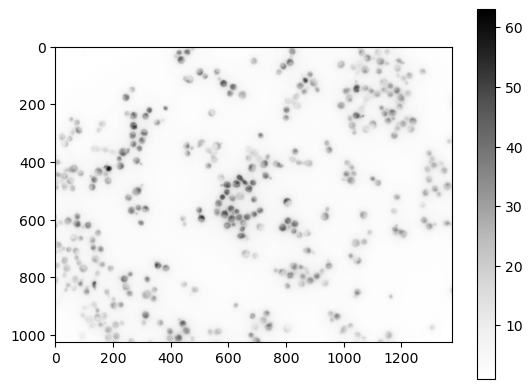

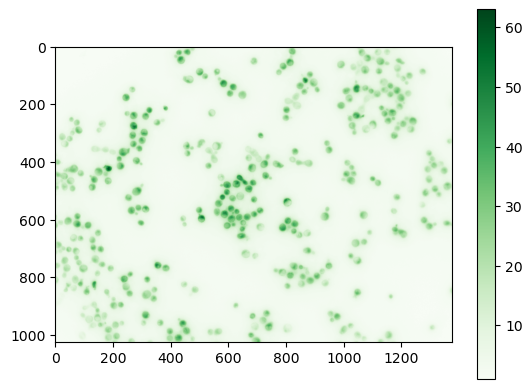

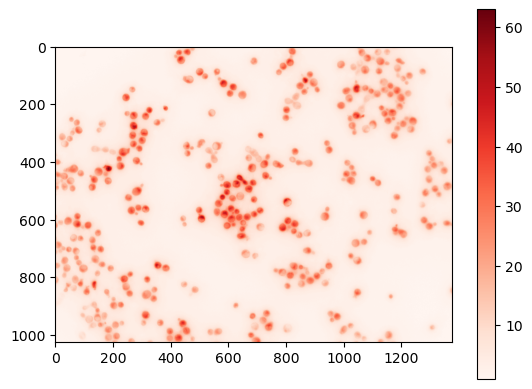

In [91]:
import glob
import cv2
from matplotlib import pyplot as plt
functional_testing_set = glob.glob('./validation/mprm1-mprm1-entr/*.tif' )
print( functional_testing_set[0 ] )
print(cv2.imread(functional_testing_set[0 ]).shape)

cscheme = [ 'Greys' , 'Greens', 'Reds' ]
sample = cv2.imread(functional_testing_set[0 ])
for channel in range(sample.shape[2] ):
    plt.imshow(sample[:,:,channel] , cmap = cscheme[channel])
    plt.colorbar()
    plt.show()

In [114]:
import pickle
#my_model = YOLO('yolov8n-seg_yfusion.pt')
#my_model = YOLO('yolov8n-seg_yfusion.pt')
my_model = model
def scaleimg(imgfile):
    #scale each input channel
    im = cv2.imread(imgfile)
    for d in range(im.shape[2]):
        page = im[:,:,d]
        page = (page - page.min()) / (page.max() - page.min()) * 255
        im[:,:,d] = page

    #im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    cv2.imwrite(imgfile +'_scaled.png', im )
    adjust_brightness_contrast(imgfile +'_scaled.png',imgfile +'_scaled.png')
    
    return imgfile +'_scaled.png'

functional_testing_set = glob.glob('./validation/mprm1-mprm1-entr/*.tif' )
predinput = [scaleimg(i) for i in functional_testing_set ]
results = { img:my_model( img , conf=0.0) for img in predinput }
with open( 'functional_test.pkl' , 'wb' ) as resout:
    resout.write( pickle.dumps( results ))


image 1/1 /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/validation/mprm1-mprm1-entr/RFP_Position001.tif_scaled.png: 768x1024 188 fs, 68 hs, 44 ls, 10.1ms
Speed: 4.3ms preprocess, 10.1ms inference, 51.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/validation/mprm1-mprm1-entr/GFP_Position010.tif_scaled.png: 768x1024 194 fs, 51 hs, 55 ls, 8.3ms
Speed: 3.7ms preprocess, 8.3ms inference, 49.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/validation/mprm1-mprm1-entr/GFP_Position007.tif_scaled.png: 768x1024 193 fs, 61 hs, 46 ls, 8.4ms
Speed: 3.7ms preprocess, 8.4ms inference, 49.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/validation/mprm1-mprm1-entr/BF_Position005.tif_scaled.png: 768x1024 79 fs, 176 hs, 45 ls, 8.4ms
Speed

In [111]:
print(results.keys())

dict_keys(['./validation/mprm1-mprm1-entr/RFP_Position001.tif_scaled.png', './validation/mprm1-mprm1-entr/GFP_Position010.tif_scaled.png', './validation/mprm1-mprm1-entr/GFP_Position007.tif_scaled.png', './validation/mprm1-mprm1-entr/BF_Position005.tif_scaled.png', './validation/mprm1-mprm1-entr/GFP_Position001.tif_scaled.png', './validation/mprm1-mprm1-entr/RFP_Position007.tif_scaled.png', './validation/mprm1-mprm1-entr/RFP_Position009.tif_scaled.png', './validation/mprm1-mprm1-entr/BF_Position007.tif_scaled.png', './validation/mprm1-mprm1-entr/BF_Position001.tif_scaled.png', './validation/mprm1-mprm1-entr/GFP_Position005.tif_scaled.png', './validation/mprm1-mprm1-entr/BF_Position010.tif_scaled.png', './validation/mprm1-mprm1-entr/RFP_Position005.tif_scaled.png'])


In [126]:
from matplotlib import patches
import tqdm

def add_rect(h,w,x,y , ax , color = 'r', label= '' ):
    # Create a Rectangle patch
    rect = patches.Rectangle((y,x), w, h, linewidth=3, edgecolor=color, facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    if len(label) > 0:
        ax.text(y - 20, x - 20 , label , )
    return ax

def plot_res(pred, imgfile):
    
    img = pred[0].orig_img
    boxes = pred[0].boxes.xywh.detach().cpu()
    c = pred[0].boxes.cls.detach().cpu()
    print(boxes)
    fig,axes = plt.subplots(nrows=1, figsize=(20,20)  , ncols=3)

    
    cscheme = [ 'Greys' , 'Greens', 'Reds' ]
    sample = cv2.imread(imgfile)
    
    for channel in range(img.shape[2] ):
        axes[channel].imshow(sample[:,:,channel] , cmap = cscheme[channel])
    for row in tqdm.tqdm(range(boxes.shape[0])):
        x,y,w,h = list( boxes[row,: ] )
        cstr = str(c[row])
        label = str( c[row] )
        for ax in list(axes):
            ax = add_rect(h=h,w=w,x=x,y=y , ax=ax , color = 'r', label= cstr )
    plt.show()


def output_pred(imgfile,my_model=my_model):
    results = list(my_model(imgfile, conf=0.9))
    plot_res(results, imgfile)


image 1/1 /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/validation/mprm1-mprm1-entr/RFP_Position001.tif_scaled.png: 768x1024 (no detections), 10.2ms
Speed: 3.9ms preprocess, 10.2ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)
tensor([], size=(0, 4))


0it [00:00, ?it/s]


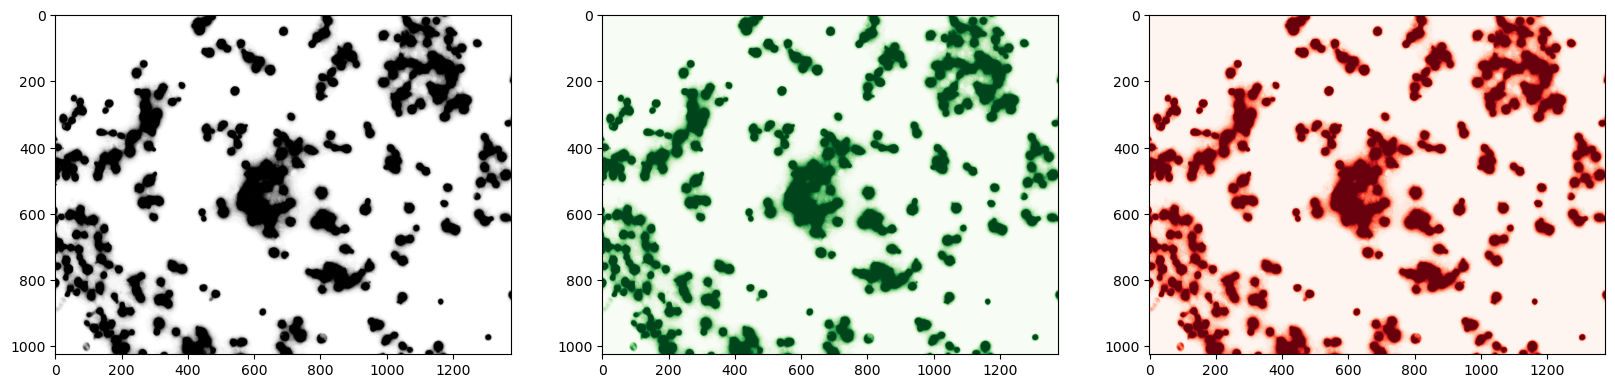

In [122]:
output_pred(predinput[0])


image 1/1 /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/datasets/test/images/img_68.png: 1024x1024 1 h, 2 ls, 10.0ms
Speed: 2.6ms preprocess, 10.0ms inference, 3.1ms postprocess per image at shape (1, 3, 1024, 1024)
tensor([[497.1770, 496.2565,  57.5438,  30.8893],
        [775.2593, 448.7802,  31.6816,  58.8315],
        [264.0513, 263.2609,  68.5909,  28.9763]])


100%|██████████| 3/3 [00:00<00:00, 368.64it/s]


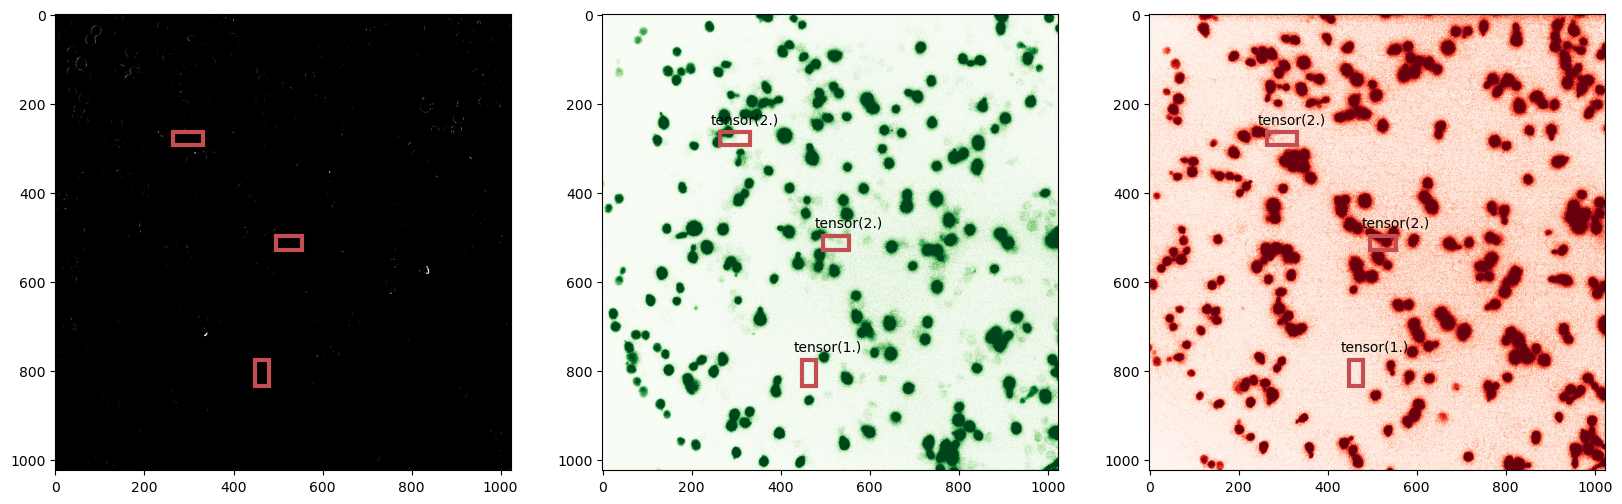

In [127]:
output_pred('datasets/test/images/img_68.png')

In [1]:
#visualize predicitions for the validation set
import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tqdm 

my_model = YOLO('runs/segment/train21/weights/best.pt')
results = list(my_model('datasets/test/images/img_57.png', conf=0.0))
result = np.asarray( results[0].conf.detach())
def retdf(model, predfile):
    resdict = { i:{ c:result[row,i] for i,c in enumerate(classes) } for i in result.shape[0] }
    resdf = pd.DataFrame(resdict)
    resdf['file'] = predfile
    return resdf

predfiles = glob.glob('*/')
global_resdf =  pd.concat([ retdf(my_model(imgfile, conf=0.0) ) for imgfile in tqdm.tdm(predfiles) ])

print(global_resdf )

NameError: name 'YOLO' is not defined

In [ ]:
print(results)

In [4]:
from IPython.display import Image as show_image
show_image(filename="runs/segment/train5/val_batch0_labelsYOLOjpg")

show_image(filename="runs/segment/train5/MaskP_curve.png")

show_image(filename="runs/segment/train5/results.png")



ValueError: Cannot embed the 'runs/segment/train5/val_batch0_labelsyolojpg' image format

In [ ]:
#augment dataset and dump to disk in pt format
